In [0]:
from google.colab import drive
import warnings
import pandas as pd
import numpy as np
import datetime
from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing import text
from keras import layers, models
drive.mount('/gdrive')
warnings.filterwarnings("ignore")

In [0]:
#datu ielasīšana
%cd '/gdrive/My Drive/LU/LU DF/8. semestris/Bakalaura Darbs/Datasets'
dataset = pd.read_csv('papildinatie_jautajumi_cleaned.csv', index_col=0)
print(dataset.shape)
X = dataset['Question'].values.astype('str')
Y = dataset['labels'].values.astype(int)
dataset['labels'].value_counts()

/gdrive/My Drive/LU/LU DF/8. semestris/Bakalaura Darbs/Datasets
(23391, 2)


1    23025
3      122
2      122
0      122
Name: labels, dtype: int64

In [0]:
max_words = 2000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)                # izveidojam Tokenizer ar noteikto vārdnīcas izmēru
tokenize.fit_on_texts(X)                                                        # apmācām Tokenizer uz mūsu datiem
X2 = tokenize.texts_to_matrix(X)                                                # pārveidojam treniņdatus par tekstvienību vektoriem
print('Tokenizer done:', max_words, X2.shape) 

Tokenizer done: 2000 (23391, 2000)


<h3>Testa datu pirmsapstrāde</h3>

In [0]:
eval_data = pd.read_excel('izvertesanas_jautajumu_kopa.xlsx')

In [0]:
import re
from bs4 import BeautifulSoup
                                                                                # Latviešu valodas stopvārdi ņemti no - https://countwordsfree.com/stopwords/latvian
STOPWORDS = ["aiz","ap","ar","apakš","ārpus","augšpus","bez","caur","dēļ","gar","iekš","iz","kopš","labad","lejpus","līdz","no","otrpus","pa","par","pār","pēc","pie","pirms","pret","priekš","starp","šaipus","uz","viņpus","virs","virspus","zem","apakšpus","un","bet","jo","ja","ka","lai","tomēr","tikko","turpretī","arī","kaut","gan","tādēļ","tā","ne","tikvien","vien","kā","ir","te","vai","kamēr","diezin","droši","diemžēl","nebūt","ik","it","taču","nu","pat","tiklab","iekšpus","nedz","tik","nevis","turpretim","jeb","iekam","iekām","iekāms","kolīdz","līdzko","tiklīdz","jebšu","tālab","tāpēc","nekā","itin","jā","jau","jel","nē","nezin","tad","tikai","vis","tak","iekams","būt","biju","biji","bija","bijām","bijāt","esmu","esi","esam","esat","būšu","būsi","būs","būsim","būsiet","tikt","tiku","tiki","tika","tikām","tikāt","tieku","tiec","tiek","tiekam","tiekat","tikšu","tiks","tiksim","tiksiet","tapt","tapi","tapāt","topat","tapšu","tapsi","taps","tapsim","tapsiet","kļūt","kļuvu","kļuvi","kļuva","kļuvām","kļuvāt","kļūstu","kļūsti","kļūst","kļūstam","kļūstat","kļūšu","kļūsi","kļūs","kļūsim","kļūsiet","varēt","varēju","varējām","varēšu","varēsim","var","varēji","varējāt","varēsi","varēsiet","varat","varēja","varēs"]
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;.]')                           # šie simboli tiks aizstāti ar tukšumu
BAD_SYMBOLS_RE = re.compile('[^a-z ēūīāšģķļžčņ]')                               # no teksta tiks izmesti visi simboli, kas nav šo simbolu sarakstā
STOPWORDS = set(STOPWORDS)                                                      # tiks izmesti visi stopvārdi

def clean_text(text):
    text = BeautifulSoup(text, "lxml").text                                     # HTML tagu izmešana
    text = text.lower()                                                         # teksta pārveidošana uz mazajiem burtiem
    text = REPLACE_BY_SPACE_RE.sub(' ', text)                                   # aizstājam simbolus, kas definēti REPLACE_BY_SPACE_RE ar tukšumu
    text = BAD_SYMBOLS_RE.sub('', text)                                         # izdzēšam sliktos simbolus kas definēti BAD_SYMBOLS_RE 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)     # izdzēšam stopvārdus no teksta
    return text

In [0]:
jautajumi = eval_data['Jautājums'].values.astype('str')
y_test = eval_data['labels']
clean_questions = []
for question in jautajumi:
  clean_question = clean_text(question)
  clean_questions.append(clean_question)
encoded = tokenize.texts_to_matrix(clean_questions)                             # pārveidojam testa datus par tekstvienību vektoriem
print('Tokenizer done:', max_words, encoded.shape)

Tokenizer done: 2000 (100, 2000)


In [0]:
def transformResults(results):
    mod_results = []
    for result in results:
        out = np.argmax(result)
        mod_results.append(out)
    mod_results = np.array(mod_results)    
    return mod_results 

<h3>OverSampling apjoms = 100%</h3>

In [0]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import f1_score
size = 2*122
thisdict = {
  1: 23025,
  3: size,
  2: size,
  0: size
}

naive_scores = []
keras_scores = []
counter = 0
print(X2.shape, Y.shape)
for i in range(10):
  oversampler = BorderlineSMOTE(sampling_strategy=thisdict)
  X_res, y_res = oversampler.fit_resample(X2, Y)                                  # Veicam Oversampling
  
  ### Naive Bayes ###
  naive_bayes = MultinomialNB()                                                   # Izveidojam Naive Bayes modeli
  naive_bayes.fit(X_res, y_res)                                                   # Trenējam modeli uz treniņdatiem
  ### Keras Sequential ###
  model = models.Sequential()
  model.add(layers.Dense(256, activation='relu', input_shape=(max_words,)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(4, activation='softmax'))
  model.compile(loss=['sparse_categorical_crossentropy'],
                optimizer='adam',
                metrics=['sparse_categorical_crossentropy'])
  history = model.fit(X_res, y_res, batch_size=64, epochs=5, verbose=0)
  y_pred = naive_bayes.predict(encoded)                                           # Prasam modelim paredzēt testa datiem kategorijas
  naive_f1_avg = round(f1_score(y_test, y_pred, average='macro'),4)               # Fiksējam Naive Bayes f1 vidējo rezultātu

  y_pred = model.predict(encoded)                                                 # Prasam modelim paredzēt testa datiem kategorijas
  keras_y_pred = transformResults(y_pred)                                         # Pārveidojam rezultātus, paņemot ticamāko klasi no varbūtībām
  keras_f1_avg = round(f1_score(y_test, keras_y_pred, average='macro'),4)         # Fiksējam Naive Bayes f1 vidējo rezultātu
  
  naive_scores.append(naive_f1_avg)
  keras_scores.append(keras_f1_avg)
  counter = counter + 1
  print('Completed iteration #',counter)
naive_final = np.mean(naive_scores)
keras_final = np.mean(keras_scores)
print('Naive scores:', naive_scores, 'Keras scores:', keras_scores)
print('Naive Bayes average score:', naive_final, 'Keras baseline average score:', keras_final)

(23391, 2000) (23391,)
Completed iteration # 1
Completed iteration # 2
Completed iteration # 3
Completed iteration # 4
Completed iteration # 5
Completed iteration # 6
Completed iteration # 7
Completed iteration # 8
Completed iteration # 9
Completed iteration # 10
Naive scores: [0.7939, 0.8118, 0.8207, 0.8118, 0.8118, 0.8118, 0.8207, 0.8207, 0.8207, 0.8207] Keras scores: [0.7449, 0.7819, 0.7659, 0.7545, 0.7537, 0.7537, 0.7449, 0.74, 0.7971, 0.7108]
Naive Bayes average score: 0.8144600000000001 Keras baseline average score: 0.7547400000000001


<h2>Atsevišķo modeļu izvērtēšana</h2>

<h3> Naive Bayes izvērtēšana - klasifikācijas atskaite un pārpratumu matrica</h3>

Naive Bayes F1 score: 0.8294
              precision    recall  f1-score   support

  akadēmisks       1.00      0.84      0.91        25
        citi       0.58      1.00      0.74        25
 darba laiks       1.00      0.64      0.78        25
   dokumenti       1.00      0.80      0.89        25

    accuracy                           0.82       100
   macro avg       0.90      0.82      0.83       100
weighted avg       0.90      0.82      0.83       100



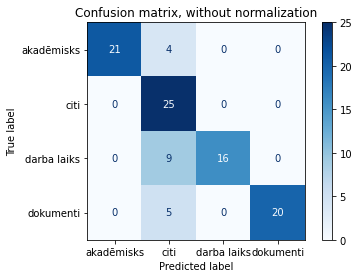

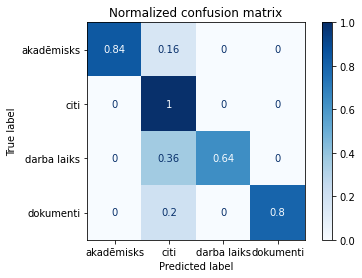

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix, f1_score, classification_report
y_pred = naive_bayes.predict(encoded)                                                 # Prasam modelim paredzēt testa datiem kategorijas
class_names = ['akadēmisks', 'citi', 'darba laiks', 'dokumenti']
naive_f1_avg = round(f1_score(y_test, y_pred, average='macro'),4)               # Fiksējam Naive Bayes f1 vidējo rezultātu
print('Naive Bayes F1 score:', naive_f1_avg)
print(classification_report(y_test, y_pred, target_names=class_names))

np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization", None),            # Plot non-normalized confusion matrix
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(naive_bayes, encoded, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

In [0]:
from sklearn.metrics import plot_confusion_matrix, f1_score, classification_report, confusion_matrix
y_pred = model.predict(encoded2)                                                       # Prasam modelim paredzēt testa datiem kategorijas
keras_y_pred = transformResults(y_pred)                                         # Pārveidojam rezultātus, paņemot ticamāko klasi no varbūtībām
class_names = ['akadēmisks', 'citi', 'darba laiks', 'dokumenti']
naive_f1_avg = round(f1_score(y_test, keras_y_pred, average='macro'),4)               # Fiksējam Naive Bayes f1 vidējo rezultātu
print('Keras F1 score:', naive_f1_avg)
print(classification_report(y_test, keras_y_pred, target_names=class_names))
print(confusion_matrix(y_test, keras_y_pred, normalize=None))
print(confusion_matrix(y_test, keras_y_pred, normalize='true'))

Keras F1 score: 0.7488
              precision    recall  f1-score   support

  akadēmisks       1.00      0.80      0.89        25
        citi       0.49      1.00      0.66        25
 darba laiks       1.00      0.44      0.61        25
   dokumenti       1.00      0.72      0.84        25

    accuracy                           0.74       100
   macro avg       0.87      0.74      0.75       100
weighted avg       0.87      0.74      0.75       100

[[20  5  0  0]
 [ 0 25  0  0]
 [ 0 14 11  0]
 [ 0  7  0 18]]
[[0.8  0.2  0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   0.56 0.44 0.  ]
 [0.   0.28 0.   0.72]]


<h3>OverSampling apjoms = 200%</h3>

In [0]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import f1_score
size = 3*122
thisdict = {
  1: 23025,
  3: size,
  2: size,
  0: size
}

naive_scores = []
keras_scores = []
counter = 0
print(X2.shape, Y.shape)
for i in range(10):
  oversampler = BorderlineSMOTE(sampling_strategy=thisdict)
  X_res, y_res = oversampler.fit_resample(X2, Y)                                  # Veicam Oversampling
  
  ### Naive Bayes ###
  naive_bayes = MultinomialNB()                                                   # Izveidojam Naive Bayes modeli
  naive_bayes.fit(X_res, y_res)                                                   # Trenējam modeli uz treniņdatiem
  ### Keras Sequential ###
  model = models.Sequential()
  model.add(layers.Dense(256, activation='relu', input_shape=(max_words,)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(4, activation='softmax'))
  model.compile(loss=['sparse_categorical_crossentropy'],
                optimizer='adam',
                metrics=['sparse_categorical_crossentropy'])
  history = model.fit(X_res, y_res, batch_size=64, epochs=5, verbose=0)
  y_pred = naive_bayes.predict(encoded)                                           # Prasam modelim paredzēt testa datiem kategorijas
  naive_f1_avg = round(f1_score(y_test, y_pred, average='macro'),4)               # Fiksējam Naive Bayes f1 vidējo rezultātu

  y_pred = model.predict(encoded)                                                 # Prasam modelim paredzēt testa datiem kategorijas
  keras_y_pred = transformResults(y_pred)                                         # Pārveidojam rezultātus, paņemot ticamāko klasi no varbūtībām
  keras_f1_avg = round(f1_score(y_test, keras_y_pred, average='macro'),4)         # Fiksējam Naive Bayes f1 vidējo rezultātu
  
  naive_scores.append(naive_f1_avg)
  keras_scores.append(keras_f1_avg)
  counter = counter + 1
  print('Completed iteration #',counter)
naive_final = round(np.mean(naive_scores),2)
keras_final = round(np.mean(keras_scores),2)
print('Naive scores:', naive_scores, 'Keras scores:', keras_scores)
print('Naive Bayes average score:', naive_final, 'Keras baseline average score:', keras_final)

(23391, 2000) (23391,)
Completed iteration # 1
Completed iteration # 2
Completed iteration # 3
Completed iteration # 4
Completed iteration # 5
Completed iteration # 6
Completed iteration # 7
Completed iteration # 8
Completed iteration # 9
Completed iteration # 10
Naive scores: [0.8664, 0.8394, 0.848, 0.848, 0.8469, 0.8463, 0.8579, 0.848, 0.8579, 0.8664] Keras scores: [0.765, 0.7491, 0.774, 0.7545, 0.774, 0.7715, 0.7634, 0.7358, 0.7659, 0.7518]
Naive Bayes average score: 0.85 Keras baseline average score: 0.76


<h2>Atsevišķo modeļu izvērtēšana</h2>

<h3> Naive Bayes izvērtēšana - klasifikācijas atskaite un pārpratumu matrica</h3>

Naive Bayes F1 score: 0.8492
              precision    recall  f1-score   support

  akadēmisks       1.00      0.84      0.91        25
        citi       0.61      1.00      0.76        25
 darba laiks       1.00      0.72      0.84        25
   dokumenti       1.00      0.80      0.89        25

    accuracy                           0.84       100
   macro avg       0.90      0.84      0.85       100
weighted avg       0.90      0.84      0.85       100



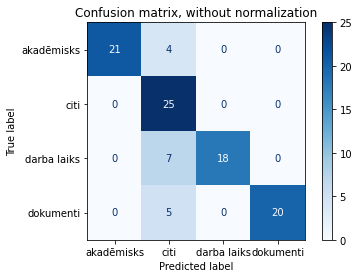

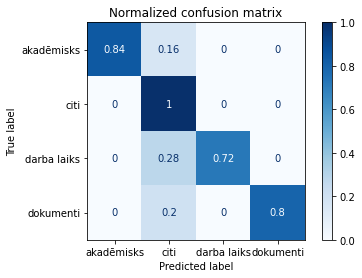

In [0]:
y_pred = naive_bayes.predict(encoded)                                            # Prasam modelim paredzēt testa datiem kategorijas
class_names = ['akadēmisks', 'citi', 'darba laiks', 'dokumenti']
naive_f1_avg = round(f1_score(y_test, y_pred, average='macro'),4)               # Fiksējam Naive Bayes f1 vidējo rezultātu
print('Naive Bayes F1 score:', naive_f1_avg)
print(classification_report(y_test, y_pred, target_names=class_names))

np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization", None),            # Plot non-normalized confusion matrix
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(naive_bayes, encoded, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

In [0]:
y_pred = model.predict(encoded2)                                                       # Prasam modelim paredzēt testa datiem kategorijas
keras_y_pred = transformResults(y_pred)                                         # Pārveidojam rezultātus, paņemot ticamāko klasi no varbūtībām
class_names = ['akadēmisks', 'citi', 'darba laiks', 'dokumenti']
naive_f1_avg = round(f1_score(y_test, keras_y_pred, average='macro'),4)               # Fiksējam Naive Bayes f1 vidējo rezultātu
print('Keras F1 score:', naive_f1_avg)
print(classification_report(y_test, keras_y_pred, target_names=class_names))
print(confusion_matrix(y_test, keras_y_pred, normalize=None))
print(confusion_matrix(y_test, keras_y_pred, normalize='true'))

Keras F1 score: 0.7537
              precision    recall  f1-score   support

  akadēmisks       1.00      0.84      0.91        25
        citi       0.50      1.00      0.67        25
 darba laiks       1.00      0.40      0.57        25
   dokumenti       1.00      0.76      0.86        25

    accuracy                           0.75       100
   macro avg       0.88      0.75      0.75       100
weighted avg       0.88      0.75      0.75       100

[[21  4  0  0]
 [ 0 25  0  0]
 [ 0 15 10  0]
 [ 0  6  0 19]]
[[0.84 0.16 0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   0.6  0.4  0.  ]
 [0.   0.24 0.   0.76]]


<h3>OverSampling apjoms = 300%</h3>

In [0]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import f1_score
size = 4*122
thisdict = {
  1: 23025,
  3: size,
  2: size,
  0: size
}

naive_scores = []
keras_scores = []
counter = 0
print(X2.shape, Y.shape)
for i in range(10):
  oversampler = BorderlineSMOTE(sampling_strategy=thisdict)
  X_res, y_res = oversampler.fit_resample(X2, Y)                                  # Veicam Oversampling
  
  ### Naive Bayes ###
  naive_bayes = MultinomialNB()                                                   # Izveidojam Naive Bayes modeli
  naive_bayes.fit(X_res, y_res)                                                   # Trenējam modeli uz treniņdatiem
  ### Keras Sequential ###
  model = models.Sequential()
  model.add(layers.Dense(256, activation='relu', input_shape=(max_words,)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(4, activation='softmax'))
  model.compile(loss=['sparse_categorical_crossentropy'],
                optimizer='adam',
                metrics=['sparse_categorical_crossentropy'])
  history = model.fit(X_res, y_res, batch_size=64, epochs=5, verbose=0)
  y_pred = naive_bayes.predict(encoded)                                           # Prasam modelim paredzēt testa datiem kategorijas
  naive_f1_avg = round(f1_score(y_test, y_pred, average='macro'),4)               # Fiksējam Naive Bayes f1 vidējo rezultātu

  y_pred = model.predict(encoded)                                                 # Prasam modelim paredzēt testa datiem kategorijas
  keras_y_pred = transformResults(y_pred)                                         # Pārveidojam rezultātus, paņemot ticamāko klasi no varbūtībām
  keras_f1_avg = round(f1_score(y_test, keras_y_pred, average='macro'),4)         # Fiksējam Naive Bayes f1 vidējo rezultātu
  
  naive_scores.append(naive_f1_avg)
  keras_scores.append(keras_f1_avg)
  counter = counter + 1
  print('Completed iteration #',counter)
naive_final = round(np.mean(naive_scores),2)
keras_final = round(np.mean(keras_scores),2)
print('Naive scores:', naive_scores, 'Keras scores:', keras_scores)
print('Naive Bayes average score:', naive_final, 'Keras baseline average score:', keras_final)

(23391, 2000) (23391,)
Completed iteration # 1
Completed iteration # 2
Completed iteration # 3
Completed iteration # 4
Completed iteration # 5
Completed iteration # 6
Completed iteration # 7
Completed iteration # 8
Completed iteration # 9
Completed iteration # 10
Naive scores: [0.848, 0.8655, 0.8655, 0.8655, 0.8655, 0.8655, 0.8565, 0.8565, 0.8655, 0.8655] Keras scores: [0.7367, 0.7767, 0.757, 0.757, 0.7265, 0.7659, 0.757, 0.757, 0.7857, 0.7529]
Naive Bayes average score: 0.86 Keras baseline average score: 0.76


<h2>Atsevišķo modeļu izvērtēšana</h2>

<h3> Naive Bayes izvērtēšana - klasifikācijas atskaite un pārpratumu matrica</h3>

Naive Bayes F1 score: 0.8655
              precision    recall  f1-score   support

  akadēmisks       1.00      0.92      0.96        25
        citi       0.64      1.00      0.78        25
 darba laiks       1.00      0.68      0.81        25
   dokumenti       1.00      0.84      0.91        25

    accuracy                           0.86       100
   macro avg       0.91      0.86      0.87       100
weighted avg       0.91      0.86      0.87       100



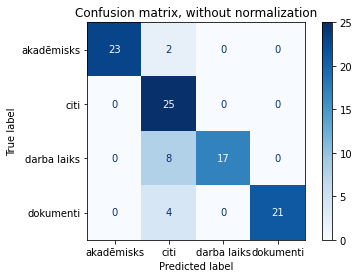

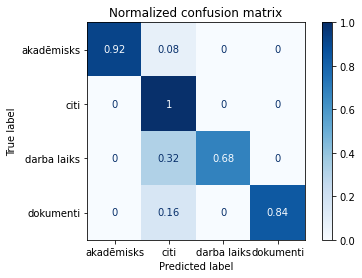

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix, f1_score, classification_report
y_pred = naive_bayes.predict(encoded)                                            # Prasam modelim paredzēt testa datiem kategorijas
class_names = ['akadēmisks', 'citi', 'darba laiks', 'dokumenti']
naive_f1_avg = round(f1_score(y_test, y_pred, average='macro'),4)               # Fiksējam Naive Bayes f1 vidējo rezultātu
print('Naive Bayes F1 score:', naive_f1_avg)
print(classification_report(y_test, y_pred, target_names=class_names))

np.set_printoptions(precision=2)
titles_options = [("Confusion matrix, without normalization", None),            # Plot non-normalized confusion matrix
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(naive_bayes, encoded, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

In [0]:
y_pred = model.predict(encoded2)                                                       # Prasam modelim paredzēt testa datiem kategorijas
keras_y_pred = transformResults(y_pred)                                         # Pārveidojam rezultātus, paņemot ticamāko klasi no varbūtībām
class_names = ['akadēmisks', 'citi', 'darba laiks', 'dokumenti']
naive_f1_avg = round(f1_score(y_test, keras_y_pred, average='macro'),4)               # Fiksējam Naive Bayes f1 vidējo rezultātu
print('Keras F1 score:', naive_f1_avg)
print(classification_report(y_test, keras_y_pred, target_names=class_names))
print(confusion_matrix(y_test, keras_y_pred, normalize=None))
print(confusion_matrix(y_test, keras_y_pred, normalize='true'))

Keras F1 score: 0.7617
              precision    recall  f1-score   support

  akadēmisks       1.00      0.88      0.94        25
        citi       0.51      1.00      0.68        25
 darba laiks       1.00      0.40      0.57        25
   dokumenti       1.00      0.76      0.86        25

    accuracy                           0.76       100
   macro avg       0.88      0.76      0.76       100
weighted avg       0.88      0.76      0.76       100

[[22  3  0  0]
 [ 0 25  0  0]
 [ 0 15 10  0]
 [ 0  6  0 19]]
[[0.88 0.12 0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   0.6  0.4  0.  ]
 [0.   0.24 0.   0.76]]


<h3>Nepareizi klasificēto jautājumu izdrukāšana</h3>

In [0]:
jautajumi = pd.read_excel('izvertesanas_jautajumu_kopa.xlsx')

In [0]:
jaut = jautajumi['Jautājums'].to_numpy()
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)
counter = 0
false_count = 0
for p in y_pred:
  if y_pred[counter] != y_test[counter]:
    false_count = false_count + 1
    print('Jautājums:', jaut[counter])
    if y_test[counter] == 0:
      print('Pareizā kategorija: Akadēmisks')
    elif y_test[counter] == 1:
      print('Pareizā kategorija: Citi')
    elif y_test[counter] == 2:
      print('Pareizā kategorija: Darba laiks')
    elif y_test[counter] == 3:
      print('Pareizā kategorija: Dokumenti')
      
    if y_pred[counter] == 0:
      print('Noteiktā kategorija: Akadēmisks')
    elif y_pred[counter] == 1:
      print('Noteiktā kategorija: Citi')
    elif y_pred[counter] == 2:
      print('Noteiktā kategorija: Darba laiks')
    elif y_pred[counter] == 3:
      print('Noteiktā kategorija: Dokumenti')
  counter = counter + 1
print('Neprecīzi noteikto jautājumu skaits:',false_count, 'no 100')  

Jautājums: Cikos tiek atvērta universitātes galvenā ēka?
Pareizā kategorija: Darba laiks
Noteiktā kategorija: Citi
Jautājums: Vai dodoties akadēmiskajā gadā es zaudēšu savu budžeta vietu?
Pareizā kategorija: Akadēmisks
Noteiktā kategorija: Citi
Jautājums: Vai 1. septembrī strādās LUSP birojs?
Pareizā kategorija: Darba laiks
Noteiktā kategorija: Citi
Jautājums: Cikos sāk strādāt studiju departaments?
Pareizā kategorija: Darba laiks
Noteiktā kategorija: Citi
Jautājums: Vai studiju pārtraukums ir tas pats, kas akadēmiskais atvaļinājums? Kā tādu noformēt?
Pareizā kategorija: Akadēmisks
Noteiktā kategorija: Citi
Jautājums: Cik ilgi drīkst atrasties LU DACā?
Pareizā kategorija: Darba laiks
Noteiktā kategorija: Citi
Jautājums: Vai ir iespējams tikt pie apliecinājuma, ka esmu studējošais?
Pareizā kategorija: Dokumenti
Noteiktā kategorija: Citi
Jautājums: Kā izskatās tas iesniegums, kas jāraksta, lai turpinātu studēt ar parādu?
Pareizā kategorija: Dokumenti
Noteiktā kategorija: Citi
Jautājums: 

<h3>Pareizi noteikto jautājumu printēšana</h3>


In [0]:
jaut = jautajumi['Jautājums'].to_numpy()
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)
counter = 0
true_count = 0
for p in y_pred:
  if y_pred[counter] == y_test[counter]:
    true_count = true_count + 1
    print('Jautājums:', jaut[counter])
    if y_test[counter] == 0:
      print('Pareizā kategorija: Akadēmisks')
    elif y_test[counter] == 1:
      print('Pareizā kategorija: Citi')
    elif y_test[counter] == 2:
      print('Pareizā kategorija: Darba laiks')
    elif y_test[counter] == 3:
      print('Pareizā kategorija: Dokumenti')
      
    if y_pred[counter] == 0:
      print('Noteiktā kategorija: Akadēmisks')
    elif y_pred[counter] == 1:
      print('Noteiktā kategorija: Citi')
    elif y_pred[counter] == 2:
      print('Noteiktā kategorija: Darba laiks')
    elif y_pred[counter] == 3:
      print('Noteiktā kategorija: Dokumenti')
  counter = counter + 1
print('Precīzi noteikto jautājumu skaits:',true_count, 'no 100')  

Jautājums: Kas jādara, lai paņemtu akadēmisko gadu?
Pareizā kategorija: Akadēmisks
Noteiktā kategorija: Akadēmisks
Jautājums: Kādi dokumenti jāiesniedz, lai dotos ERASMUS?
Pareizā kategorija: Dokumenti
Noteiktā kategorija: Dokumenti
Jautājums: Kāds ir LU DAC darba laiks brīvdienās?
Pareizā kategorija: Darba laiks
Noteiktā kategorija: Darba laiks
Jautājums: Līdz cikiem strādā bibliotēka?
Pareizā kategorija: Darba laiks
Noteiktā kategorija: Darba laiks
Jautājums: Ar ko jāsaskaņo reklāmas materiālu izvietošana LU telpās?
Pareizā kategorija: Citi
Noteiktā kategorija: Citi
Jautājums: Vai akadēmisko gadu var paņemt atkārtoti?
Pareizā kategorija: Akadēmisks
Noteiktā kategorija: Akadēmisks
Jautājums: Kādi papīri nepieciešami, lai reģistrētos pamatstudijām?
Pareizā kategorija: Dokumenti
Noteiktā kategorija: Dokumenti
Jautājums: Vai LU bibliotēkās ir atrodamas Harija Potera grāmatas?
Pareizā kategorija: Citi
Noteiktā kategorija: Citi
Jautājums: Vai akadēmisko gadu var ņemt, ja man ir parādi?
Par